In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import defaultdict
from datetime import datetime, timedelta
%matplotlib inline

In [2]:
# !tail apple_health_export/export.xml

In [3]:
data = defaultdict(list)

with open('apple_health_export/export.xml', 'r') as f:
    for line in f:
        if re.search('^[\s]*<Record ', line):
            for x in re.findall(r'([\w]*)="([\w\.\+\:\-\s]*)"' , line):
                k, v = x
                data[k].append(v)

# add missing unit                
unit = data.pop('unit')
df = pd.DataFrame({x:data[x] for x in data.keys()}, )
df['unit'] = None
df.loc[df.index < len(unit), 'unit'] = unit

# convert datetime daata
df.creationDate  = pd.to_datetime(df.creationDate.astype(str).str[:19]).apply(lambda x: x.date())
df.startDate = pd.to_datetime(df.startDate.astype(str).str[:19])
df.endDate = pd.to_datetime(df.endDate.astype(str).str[:19])

In [4]:
df2 = df.type.astype(str).str.extract('([\w]*)Identifier([\w]*)')
df['type'] = df2[1].values
print df.head()

print '____________________________________________________________________'
print 'Activity types :', df.type.unique()

  creationDate             endDate sourceName sourceVersion  \
0   2017-06-04 2017-06-04 22:00:52     Health        10.3.2   
1   2017-06-04 2017-06-04 22:00:52     Health        10.3.2   
2   2017-06-04 2017-06-04 19:58:57     iPhone        10.3.2   
3   2017-06-04 2017-06-04 20:08:56     iPhone        10.3.2   
4   2017-06-04 2017-06-04 20:18:27     iPhone        10.3.2   

            startDate       type value   unit  
0 2017-06-04 22:00:52     Height   168     cm  
1 2017-06-04 22:00:52   BodyMass    73     kg  
2 2017-06-04 19:52:18  StepCount    13  count  
3 2017-06-04 19:58:57  StepCount   324  count  
4 2017-06-04 20:08:56  StepCount   840  count  
____________________________________________________________________
Activity types : ['Height' 'BodyMass' 'StepCount' 'DistanceWalkingRunning' 'FlightsClimbed'
 'SleepAnalysis']


/home/tam/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.


/usr/local/lib/python2.7/dist-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


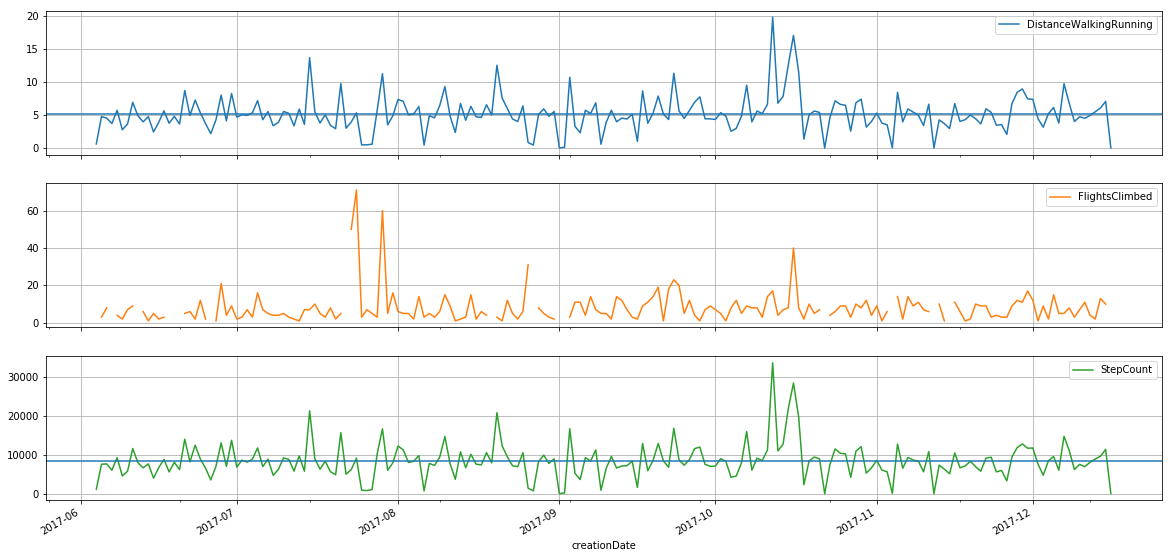

In [5]:
activity_types = ['StepCount', 'DistanceWalkingRunning', 'FlightsClimbed']
df2 = df[df.type.isin(activity_types)]
df2.value = df2.value.astype(float)
df2 = df2.groupby(['creationDate', 'type'])['value'].sum().unstack()
# plot data
axs = df2.plot(subplots=True, grid=True, figsize=(20, 10))
axs[0].axhline(y=df2.DistanceWalkingRunning.mean())
axs[2].axhline(y=df2.StepCount.mean())
plt.show()

In [6]:
activity_types = ['StepCount', 'DistanceWalkingRunning', 'FlightsClimbed']
# df2 = df[df.type.isin(activity_types)]
# df2 = df2[df2.type == 'StepCount']
# df2['value'] = df2['value'].astype(float)

# step count
sc_df = df[df.type == 'StepCount']
sc_df['startHour'] = sc_df.startDate.apply(lambda x: x.hour)
sc_df['value'] = sc_df.value.astype(int)

sc_df = sc_df.groupby(['creationDate', 'startHour'])['value'].sum()
sc_df = sc_df.unstack('creationDate')
sc_df = sc_df.fillna(0)

# DistanceWalkingRunning
dwr_df = df[df.type == 'DistanceWalkingRunning']
dwr_df['startHour'] = dwr_df.startDate.apply(lambda x: x.hour)
dwr_df['value'] = dwr_df.value.astype(float)

dwr_df = dwr_df.groupby(['creationDate', 'startHour'])['value'].sum()
dwr_df = dwr_df.unstack('creationDate')
dwr_df = dwr_df.fillna(0)

# sc_df.head()

/home/tam/.local/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/tam/.local/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/tam/.local/lib/python2.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pan

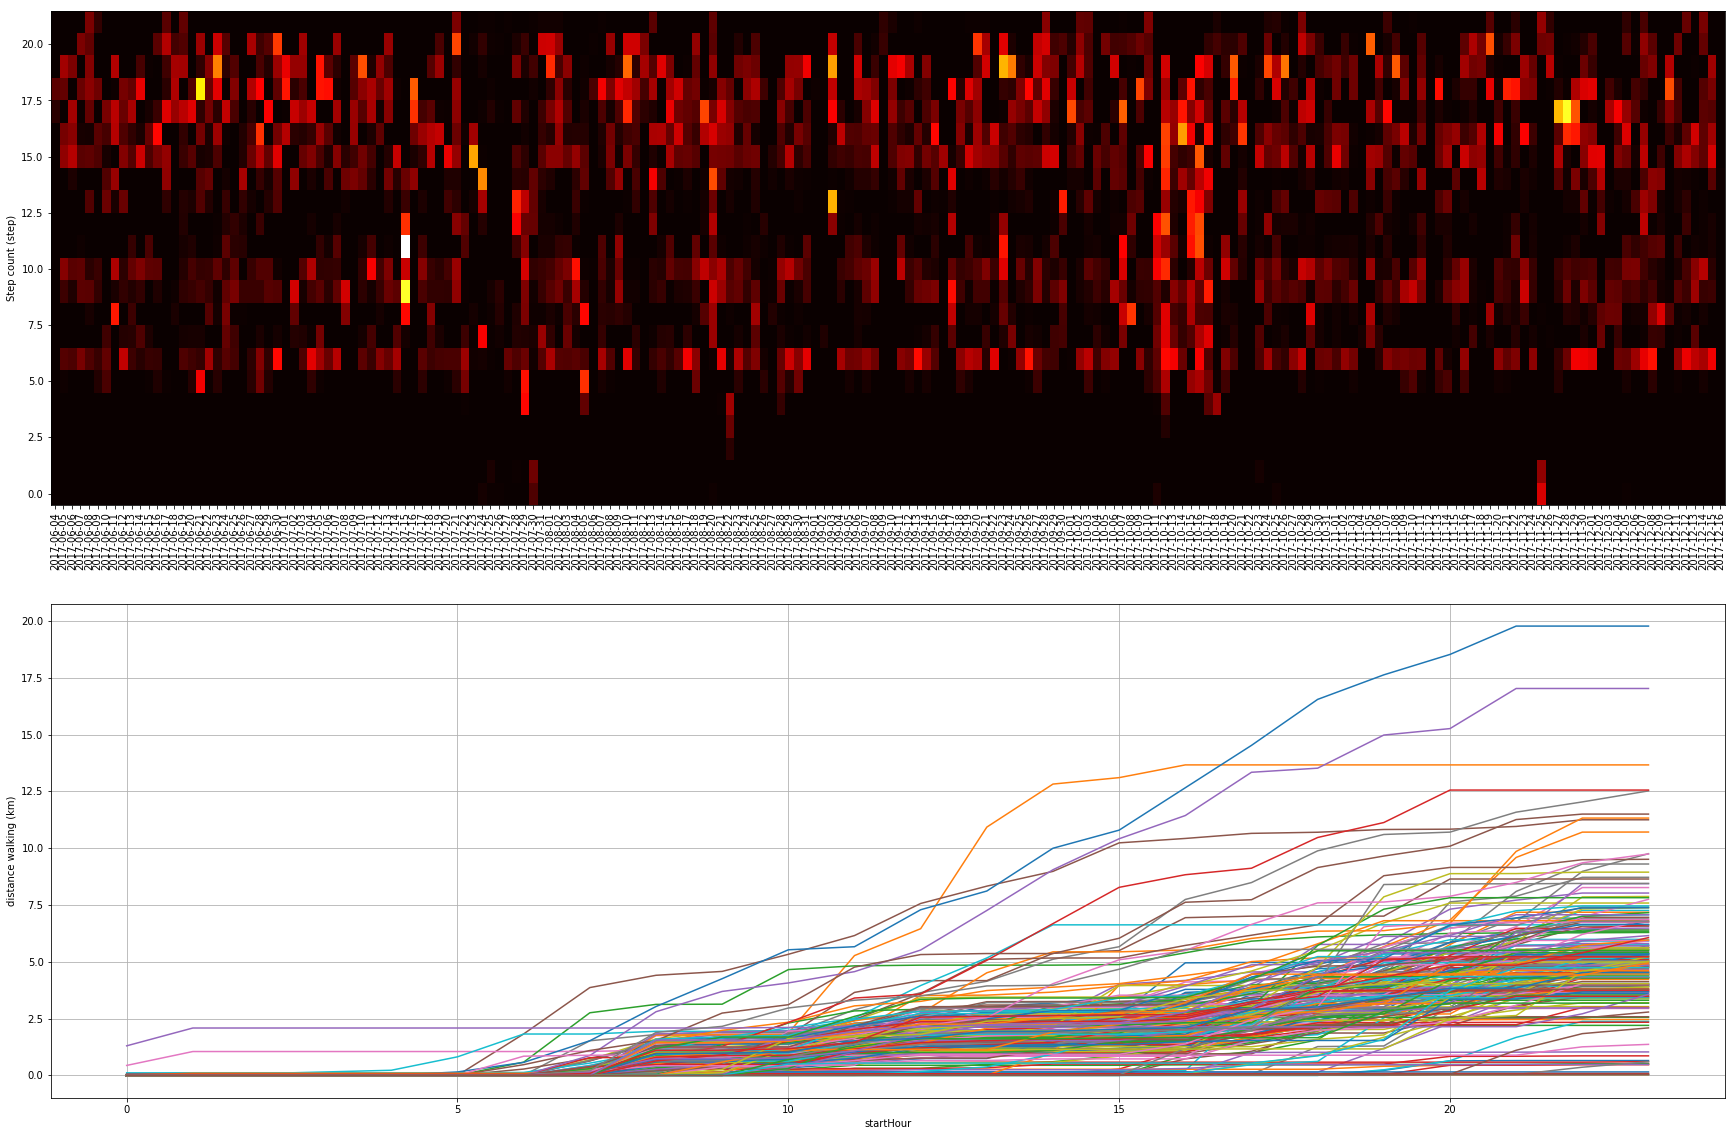

In [7]:
fig = plt.figure()
nb_images = 2
ax = fig.add_subplot(nb_images,1,1)

img = ax.imshow(sc_df, origin='lower', cmap='hot', aspect='auto', interpolation='None')
ax.set_xticks(range(sc_df.shape[1]))
ax.set_xticklabels(sc_df.columns.values, rotation='vertical')
ax.set_ylabel('Step count (step)')
# fig.colorbar(img, ax=ax)

ax = fig.add_subplot(nb_images,1,2)
dwr_df.cumsum().plot(figsize=(20, 20), legend=False, ax=ax, grid=True)
ax.set_ylabel('distance walking (km)')

fig.set_size_inches(30, 20)
plt.show()

In [8]:
sleep_df = df[(df.type =='SleepAnalysis') & (df.value =='HKCategoryValueSleepAnalysisInBed')]
sleep_df['startTime'] = df.startDate.apply(lambda x: x.time())
sleep_df['endTime'] = df.endDate.apply(lambda x: x.time())
sleep_df

/home/tam/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/tam/.local/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


creationDate             endDate sourceName sourceVersion  \
14154   2017-06-07 2017-06-07 07:30:40      Clock            50   
14155   2017-06-08 2017-06-08 07:30:09      Clock            50   
14156   2017-06-10 2017-06-10 07:30:31      Clock            50   
14157   2017-06-12 2017-06-12 07:30:21      Clock            50   
14158   2017-06-13 2017-06-13 07:30:32      Clock            50   
14159   2017-06-14 2017-06-14 07:02:24      Clock            50   
14160   2017-06-14 2017-06-14 07:02:24      Clock            50   
14161   2017-06-14 2017-06-14 07:30:57      Clock            50   
14162   2017-06-14 2017-06-14 07:40:36      Clock            50   
14163   2017-06-14 2017-06-14 07:52:08      Clock            50   
14164   2017-06-14 2017-06-14 08:00:08      Clock            50   
14165   2017-06-14 2017-06-14 08:32:44      Clock            50   
14166   2017-06-14 2017-06-14 08:35:44      Clock            50   
14167   2017-06-15 2017-06-15 07:40:12      Clock            50   
14168   2017-06-15 2017-06-15 07:49:04      Clock            50   
14169   2017-06-15 2017-06-15 08:06:40      Clock            50   
14170   2017-06-15 2017-06-15 08:11:28      Clock            50   
14171   2017-06-15 2017-06-15 08:15:40      Clock            50   
14172   2017-06-15 2017-06-15 08:38:00      Clock            50   
14173   2017-06-16 2017-06-16 07:30:24      Clock            50   
14174   2017-06-16 2017-06-16 07:59:08      Clock            50   
14175   2017-06-19 2017-06-19 07:52:56      Clock            50   
14176   2017-06-19 2017-06-19 07:56:03      Clock            50   
14177   2017-06-20 2017-06-20 07:31:16      Clock            50   
14178   2017-06-20 2017-06-20 07:55:06      Clock            50   
14179   2017-06-21 2017-06-21 07:09:28      Clock            50   
14180   2017-06-21 2017-06-21 07:15:00      Clock            50   
14181   2017-06-21 2017-06-21 07:27:28      Clock            50   
14182   2017-06-21 2017-06-21 07:34:36      Clock            50   
14183   2017-06-21 2017-06-21 07:55:09      Clock            50   
14184   2017-06-22 2017-06-22 07:10:52      Clock            50   
14185   2017-06-22 2017-06-22 07:20:08      Clock            50   
14186   2017-06-22 2017-06-22 07:53:36      Clock            50   
14187   2017-06-22 2017-06-22 07:55:16      Clock            50   
14188   2017-06-24 2017-06-24 07:04:28      Clock            50   
14189   2017-06-24 2017-06-24 07:48:08      Clock            50   
14190   2017-06-24 2017-06-24 07:56:12      Clock            50   
14191   2017-06-26 2017-06-26 07:30:12      Clock            50   
14192   2017-06-26 2017-06-26 07:46:48      Clock            50   
14193   2017-06-26 2017-06-26 07:55:45      Clock            50   
14194   2017-06-28 2017-06-28 07:31:28      Clock            50   
14195   2017-06-28 2017-06-28 07:55:31      Clock            50   
14196   2017-06-29 2017-06-29 07:29:24      Clock            50   
14197   2017-06-29 2017-06-29 08:02:08      Clock            50   
14198   2017-07-03 2017-07-03 07:31:04      Clock            50   
14199   2017-07-03 2017-07-03 08:14:52      Clock            50   
14200   2017-07-05 2017-07-05 07:34:28      Clock            50   
14201   2017-07-05 2017-07-05 07:56:58      Clock            50   
14202   2017-07-06 2017-07-06 07:30:12      Clock            50   
14203   2017-07-06 2017-07-06 07:47:48      Clock            50   
14204   2017-07-06 2017-07-06 07:55:03      Clock            50   
14205   2017-07-07 2017-07-07 07:30:56      Clock            50   
14206   2017-07-07 2017-07-07 08:02:59      Clock            50   
14207   2017-07-08 2017-07-08 07:40:52      Clock            50   
14208   2017-07-08 2017-07-08 07:55:36      Clock            50   

                startDate           type                              value  \
14154 2017-06-07 00:30:00  SleepAnalysis  HKCategoryValueSleepAnalysisInBed   
14155 2017-06-08 00:44:04  SleepAnalysis  HKCategoryValueSleepAnalysisInBed   
14156 2017-06-10

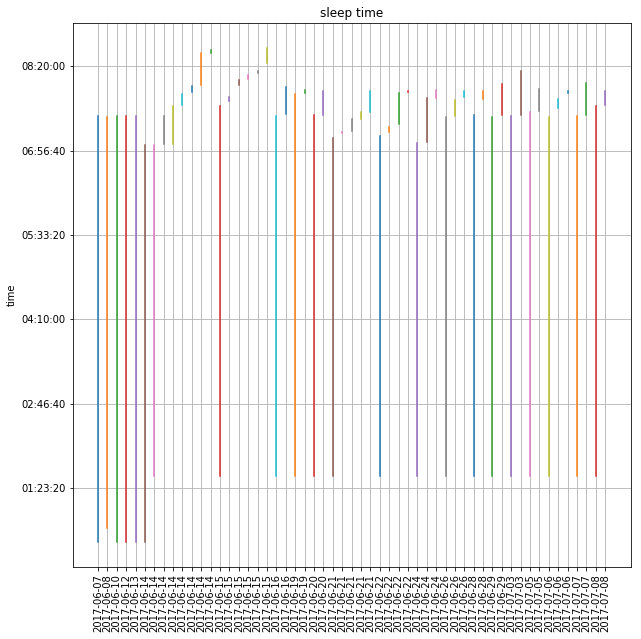

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i, r in sleep_df.iterrows():
    ax.plot([i, i], [r['startTime'], r['endTime']])
ax.set_xticks(sleep_df.index)
ax.set_xticklabels(sleep_df.creationDate, rotation='vertical')
ax.set_title('sleep time')
ax.grid()
fig.set_size_inches(10, 10)